Pilar Navarro Ramírez

In [7]:
import pandas as pd
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, AveragePooling2D,Dropout
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

sns.set(style='white', context='notebook', palette='deep')

%matplotlib inline

In [9]:
#########################################################################
## FUNCIÓN PARA PINTAR LA PÉRDIDA Y EL ACCURACY EN TRAIN Y VALIDACIÓN ###
#########################################################################

# Esta función pinta dos gráficas, una con la evolución
# de la función de pérdida en el conjunto de train y
# en el de validación, y otra con la evolución de la
# accuracy en el conjunto de train y el de validación.
# Es necesario pasarle como parámetro el historial del
# entrenamiento del modelo (lo que devuelven las
# funciones fit() y fit_generator()).
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy','Validation accuracy'])
    plt.show()

## Lectura de los datos y preprocesamiento

In [10]:
mndata = MNIST('data')

x_train, y_train = mndata.load_training()
x_test, y_test = mndata.load_testing()

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [11]:
x_train = x_train.reshape((len(x_train),28,28))
x_test = x_test.reshape((len(x_test),28,28))

In [12]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [13]:
y_train=pd.DataFrame(y_train)

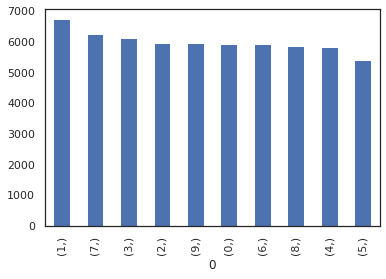

In [14]:
hist = y_train.value_counts()
hist.plot.bar()

In [15]:
#normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

In [16]:
#reshape
x_train = x_train.reshape(-1, 28,28,1)
x_test = x_test.reshape(-1, 28,28,1)
# Padding the input to make it 32x32. 
x_train = np.pad(x_train, [(0, 0), (2, 2), (2, 2), (0, 0)], "constant") 
x_test = np.pad(x_test, [(0, 0), (2, 2), (2, 2), (0, 0)], "constant") 

In [17]:
#Convert the data into 3 dimensions
train=x_train.copy()
test=x_test.copy()

train=train.reshape(-1,32,32)
test=test.reshape(-1,32,32)

train=np.stack([train,train,train],axis=-1)
test=np.stack([test,test,test],axis=-1)

In [18]:
print("X_train shape: ", train.shape)
print("x_test shape: ", test.shape)

X_train shape:  (60000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)


In [19]:
#label encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [20]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [21]:
#split data into training and validation
train, val, y_train, y_val = train_test_split(train, y_train, test_size = 0.1, random_state = 2)

In [22]:
print("X_train shape: ", train.shape)
print("X_val shape: ", val.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (54000, 32, 32, 3)
X_val shape:  (6000, 32, 32, 3)
y_train shape:  (54000, 10)
y_val shape:  (6000, 10)


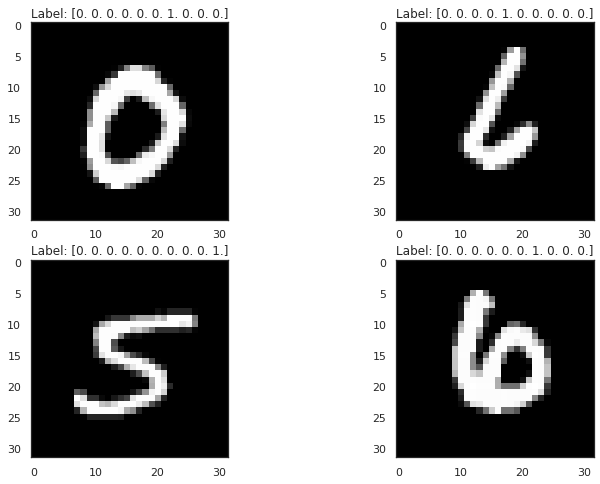

In [23]:
nrows = 2
ncols = 2

pic_indexes = np.random.randint(train.shape[0], size=(nrows*ncols))

f, axs = plt.subplots(nrows, ncols, figsize=(12, 8))
axs = axs.flatten()

picture_index  = 0

for picture_index, ax in zip(pic_indexes, axs):
        ax.imshow(x_train[picture_index].reshape(32, 32), cmap='gray')
        ax.set_title(f'Label: {y_train[picture_index]}')

plt.show()

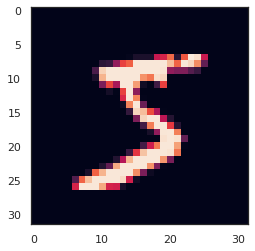

In [24]:
g = plt.imshow(x_train[0][:,:,0])

## VGG16

In [ ]:
def nuevoVGG16():
    model = Sequential()

    model.add(VGG16(weights='imagenet', include_top=False, input_shape = (32,32,3)))


    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))

    return model

In [ ]:
model = nuevoVGG16()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].trainable = False

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer = Adam(1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs = 50 
batch_size = 64
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 6, restore_best_weights=True), 
    ReduceLROnPlateau(monitor = 'val_loss', patience = 3)
]

In [ ]:
# Fit the model
history1 = model.fit(train,y_train, batch_size=batch_size,
                    epochs = epochs, validation_data = (val,y_val),
                    verbose = 2, steps_per_epoch=train.shape[0] // batch_size,
                    callbacks = callbacks1)

Epoch 1/50
843/843 - 6s - loss: 1.1201 - accuracy: 0.6534 - val_loss: 0.6279 - val_accuracy: 0.8297
Epoch 2/50
843/843 - 5s - loss: 0.5683 - accuracy: 0.8304 - val_loss: 0.4147 - val_accuracy: 0.8890
Epoch 3/50
843/843 - 5s - loss: 0.4198 - accuracy: 0.8761 - val_loss: 0.3184 - val_accuracy: 0.9137
Epoch 4/50
843/843 - 5s - loss: 0.3461 - accuracy: 0.8985 - val_loss: 0.2670 - val_accuracy: 0.9257
Epoch 5/50
843/843 - 5s - loss: 0.2949 - accuracy: 0.9133 - val_loss: 0.2309 - val_accuracy: 0.9347
Epoch 6/50
843/843 - 5s - loss: 0.2624 - accuracy: 0.9224 - val_loss: 0.2060 - val_accuracy: 0.9393
Epoch 7/50
843/843 - 5s - loss: 0.2387 - accuracy: 0.9291 - val_loss: 0.1897 - val_accuracy: 0.9443
Epoch 8/50
843/843 - 5s - loss: 0.2202 - accuracy: 0.9337 - val_loss: 0.1733 - val_accuracy: 0.9470
Epoch 9/50
843/843 - 5s - loss: 0.2050 - accuracy: 0.9370 - val_loss: 0.1619 - val_accuracy: 0.9513
Epoch 10/50
843/843 - 6s - loss: 0.1938 - accuracy: 0.9409 - val_loss: 0.1545 - val_accuracy: 0.9533

#### Fine Tuning

In [ ]:
model.layers[0].trainable = True

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=Adam(1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs = 20 
batch_size = 32
callbacks2 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights=True), 
    ReduceLROnPlateau(monitor = 'val_loss', patience = 3)
]

In [ ]:
# Fit the model
history2 = model.fit(train,y_train, batch_size=batch_size,
                    epochs = epochs, validation_data = (val,y_val),
                    verbose = 2, steps_per_epoch=train.shape[0] // batch_size,
                    callbacks = callbacks2)

Epoch 1/20
1687/1687 - 19s - loss: 0.0767 - accuracy: 0.9769 - val_loss: 0.0358 - val_accuracy: 0.9895
Epoch 2/20
1687/1687 - 18s - loss: 0.0353 - accuracy: 0.9896 - val_loss: 0.0384 - val_accuracy: 0.9898
Epoch 3/20
1687/1687 - 18s - loss: 0.0276 - accuracy: 0.9915 - val_loss: 0.0285 - val_accuracy: 0.9922
Epoch 4/20
1687/1687 - 18s - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0265 - val_accuracy: 0.9927
Epoch 5/20
1687/1687 - 18s - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.0272 - val_accuracy: 0.9928
Epoch 6/20
1687/1687 - 18s - loss: 0.0136 - accuracy: 0.9956 - val_loss: 0.0400 - val_accuracy: 0.9908
Epoch 7/20
1687/1687 - 18s - loss: 0.0143 - accuracy: 0.9959 - val_loss: 0.0218 - val_accuracy: 0.9950
Epoch 8/20
1687/1687 - 18s - loss: 0.0109 - accuracy: 0.9968 - val_loss: 0.0215 - val_accuracy: 0.9938
Epoch 9/20
1687/1687 - 18s - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0418 - val_accuracy: 0.9922
Epoch 10/20
1687/1687 - 18s - loss: 0.0078 - accuracy: 0.9977 - val_loss:

In [ ]:
# Confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Result

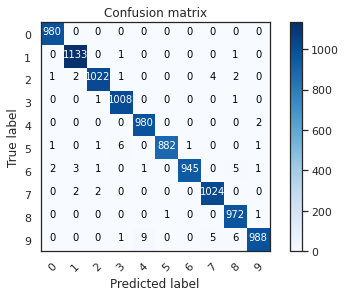

In [ ]:
# Predict the values from the test dataset
y_pred = model.predict(test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert test observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [ ]:
score = model.evaluate(test, y_test, verbose = 0)
print("Test Accuracy: ",score[1])

Test Accuracy:  0.993399977684021


In [ ]:
result = model.predict(x_test)

result = np.argmax(result, axis=1)

result = pd.Series(result, name='Label')

result.head()

0    7
1    2
2    1
3    0
4    4
Name: Label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '(Test data) Number of Digits classes predicted')

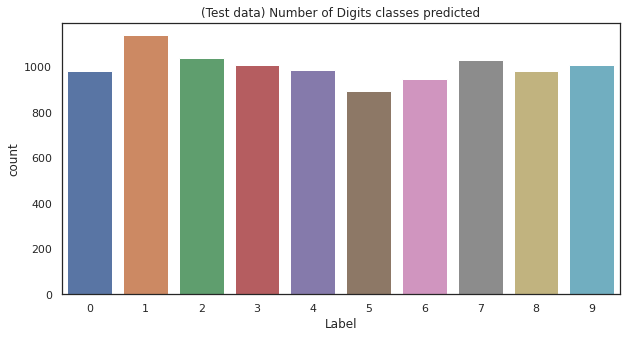

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(result)
plt.title("(Test data) Number of Digits classes predicted")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '(Test data) Number of Digits classes real')

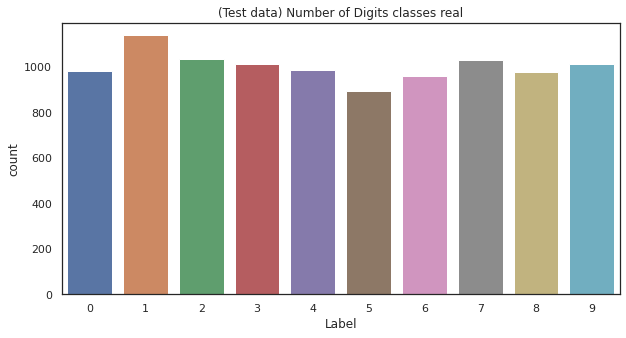

In [ ]:
plt.figure(figsize=(10,5))
y_true = pd.Series(y_true, name='Label')
sns.countplot(y_true)
plt.title("(Test data) Number of Digits classes real")

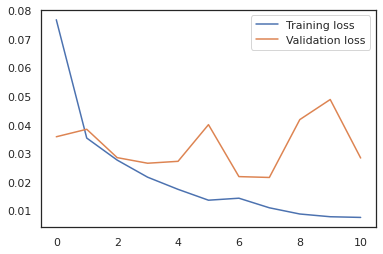

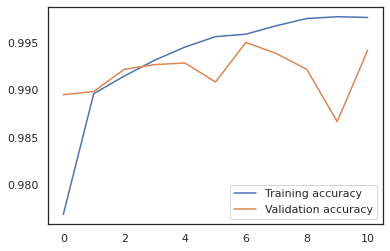

In [ ]:
mostrarEvolucion(history)

### Con data augmentation

In [ ]:
model = nuevoVGG16()

#Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train)

In [ ]:
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer = Adam(1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs = 50 
batch_size = 64
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True), 
    ReduceLROnPlateau(monitor = 'val_loss', patience = 3)
]

In [ ]:
# Fit the model
history1 = model.fit(datagen.flow(train,y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = (val,y_val),
                    verbose = 2, steps_per_epoch=train.shape[0] // batch_size,
                    callbacks = callbacks1)

Epoch 1/50
843/843 - 29s - loss: 1.2339 - accuracy: 0.6060 - val_loss: 0.7105 - val_accuracy: 0.7850
Epoch 2/50
843/843 - 28s - loss: 0.6825 - accuracy: 0.7900 - val_loss: 0.4993 - val_accuracy: 0.8517
Epoch 3/50
843/843 - 28s - loss: 0.5344 - accuracy: 0.8358 - val_loss: 0.4000 - val_accuracy: 0.8807
Epoch 4/50
843/843 - 28s - loss: 0.4517 - accuracy: 0.8604 - val_loss: 0.3467 - val_accuracy: 0.8985
Epoch 5/50
843/843 - 28s - loss: 0.3958 - accuracy: 0.8793 - val_loss: 0.3174 - val_accuracy: 0.9025
Epoch 6/50
843/843 - 28s - loss: 0.3602 - accuracy: 0.8886 - val_loss: 0.2881 - val_accuracy: 0.9103
Epoch 7/50
843/843 - 28s - loss: 0.3322 - accuracy: 0.8974 - val_loss: 0.2723 - val_accuracy: 0.9152
Epoch 8/50
843/843 - 28s - loss: 0.3087 - accuracy: 0.9043 - val_loss: 0.2514 - val_accuracy: 0.9225
Epoch 9/50
843/843 - 28s - loss: 0.2926 - accuracy: 0.9096 - val_loss: 0.2512 - val_accuracy: 0.9198
Epoch 10/50
843/843 - 28s - loss: 0.2793 - accuracy: 0.9125 - val_loss: 0.2373 - val_accura

#### Fine Tuning

In [ ]:
model.layers[0].trainable = True

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=Adam(1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs = 20 
batch_size = 64
callbacks2 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights=True), 
    ReduceLROnPlateau(monitor = 'val_loss', patience = 3)
]

In [ ]:
# Fit the model
history2 = model.fit(datagen.flow(train,y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = (val,y_val),
                    verbose = 2, steps_per_epoch=train.shape[0] // batch_size,
                    callbacks = callbacks2)

Epoch 1/20
843/843 - 33s - loss: 0.0952 - accuracy: 0.9694 - val_loss: 0.0368 - val_accuracy: 0.9888
Epoch 2/20
843/843 - 31s - loss: 0.0515 - accuracy: 0.9836 - val_loss: 0.0395 - val_accuracy: 0.9883
Epoch 3/20
843/843 - 30s - loss: 0.0378 - accuracy: 0.9891 - val_loss: 0.0396 - val_accuracy: 0.9893
Epoch 4/20
843/843 - 31s - loss: 0.0330 - accuracy: 0.9893 - val_loss: 0.0303 - val_accuracy: 0.9912
Epoch 5/20
843/843 - 30s - loss: 0.0271 - accuracy: 0.9915 - val_loss: 0.0406 - val_accuracy: 0.9878
Epoch 6/20
843/843 - 30s - loss: 0.0238 - accuracy: 0.9921 - val_loss: 0.0298 - val_accuracy: 0.9912
Epoch 7/20
843/843 - 30s - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0249 - val_accuracy: 0.9928
Epoch 8/20
843/843 - 30s - loss: 0.0207 - accuracy: 0.9937 - val_loss: 0.0257 - val_accuracy: 0.9942
Epoch 9/20
843/843 - 30s - loss: 0.0185 - accuracy: 0.9945 - val_loss: 0.0352 - val_accuracy: 0.9923
Epoch 10/20
843/843 - 30s - loss: 0.0176 - accuracy: 0.9943 - val_loss: 0.0255 - val_accura

#### Result

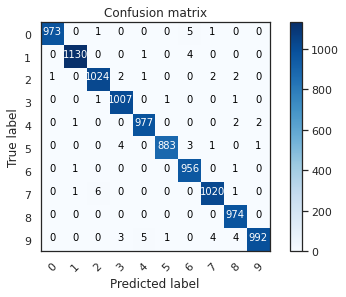

In [ ]:
# Predict the values from the test dataset
y_pred = model.predict(test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert test observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [ ]:
score = model.evaluate(test, y_test, verbose = 0)
print("Test Accuracy: ",score[1])

Test Accuracy:  0.9936000108718872


## VGG19

In [50]:
def nuevoVGG19():
    model = Sequential()

    model.add(VGG19(weights='imagenet', include_top=False, input_shape = (32,32,3)))


    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))

    return model

In [51]:
model = nuevoVGG19()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 20,292,170
Trainable params: 20,292,170
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.layers[0].trainable = False

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 20,292,170
Trainable params: 267,786
Non-trainable params: 20,024,384
_________________________________________________________________


In [54]:
model.compile(optimizer = Adam(1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [55]:
epochs = 50 
batch_size = 64
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 6, restore_best_weights=True), 
    ReduceLROnPlateau(monitor = 'val_loss', patience = 3)
]

In [56]:
# Fit the model
history1 = model.fit(train,y_train, batch_size=batch_size,
                    epochs = epochs, validation_data = (val,y_val),
                    verbose = 2, steps_per_epoch=train.shape[0] // batch_size,
                    callbacks = callbacks1)

Epoch 1/50
843/843 - 13s - loss: 1.1118 - accuracy: 0.6648 - val_loss: 0.5778 - val_accuracy: 0.8593
Epoch 2/50
843/843 - 12s - loss: 0.5143 - accuracy: 0.8561 - val_loss: 0.3681 - val_accuracy: 0.9025
Epoch 3/50
843/843 - 12s - loss: 0.3700 - accuracy: 0.8951 - val_loss: 0.2814 - val_accuracy: 0.9253
Epoch 4/50
843/843 - 12s - loss: 0.3012 - accuracy: 0.9138 - val_loss: 0.2368 - val_accuracy: 0.9338
Epoch 5/50
843/843 - 13s - loss: 0.2601 - accuracy: 0.9232 - val_loss: 0.2047 - val_accuracy: 0.9390
Epoch 6/50
843/843 - 12s - loss: 0.2327 - accuracy: 0.9310 - val_loss: 0.1867 - val_accuracy: 0.9437
Epoch 7/50
843/843 - 12s - loss: 0.2111 - accuracy: 0.9364 - val_loss: 0.1781 - val_accuracy: 0.9447
Epoch 8/50
843/843 - 12s - loss: 0.1959 - accuracy: 0.9407 - val_loss: 0.1598 - val_accuracy: 0.9485
Epoch 9/50
843/843 - 12s - loss: 0.1852 - accuracy: 0.9437 - val_loss: 0.1509 - val_accuracy: 0.9517
Epoch 10/50
843/843 - 12s - loss: 0.1758 - accuracy: 0.9464 - val_loss: 0.1434 - val_accura

#### Fine Tuning

In [57]:
model.layers[0].trainable = True

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 20,292,170
Trainable params: 20,292,170
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(optimizer=Adam(1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [60]:
epochs = 20 
batch_size = 32
callbacks2 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights=True), 
    ReduceLROnPlateau(monitor = 'val_loss', patience = 3)
]

In [61]:
# Fit the model
history2 = model.fit(train,y_train, batch_size=batch_size,
                    epochs = epochs, validation_data = (val,y_val),
                    verbose = 2, steps_per_epoch=train.shape[0] // batch_size,
                    callbacks = callbacks2)

Epoch 1/20
1687/1687 - 63s - loss: 0.0830 - accuracy: 0.9746 - val_loss: 0.0457 - val_accuracy: 0.9868
Epoch 2/20
1687/1687 - 62s - loss: 0.0418 - accuracy: 0.9871 - val_loss: 0.0246 - val_accuracy: 0.9923
Epoch 3/20
1687/1687 - 62s - loss: 0.0293 - accuracy: 0.9904 - val_loss: 0.0324 - val_accuracy: 0.9898
Epoch 4/20
1687/1687 - 62s - loss: 0.0250 - accuracy: 0.9918 - val_loss: 0.0239 - val_accuracy: 0.9923
Epoch 5/20
1687/1687 - 61s - loss: 0.0204 - accuracy: 0.9940 - val_loss: 0.0238 - val_accuracy: 0.9927
Epoch 6/20
1687/1687 - 61s - loss: 0.0174 - accuracy: 0.9946 - val_loss: 0.0244 - val_accuracy: 0.9933
Epoch 7/20
1687/1687 - 61s - loss: 0.0142 - accuracy: 0.9958 - val_loss: 0.0223 - val_accuracy: 0.9938
Epoch 8/20
1687/1687 - 61s - loss: 0.0110 - accuracy: 0.9970 - val_loss: 0.0276 - val_accuracy: 0.9918
Epoch 9/20
1687/1687 - 62s - loss: 0.0128 - accuracy: 0.9962 - val_loss: 0.0329 - val_accuracy: 0.9928
Epoch 10/20
1687/1687 - 61s - loss: 0.0104 - accuracy: 0.9970 - val_loss:

#### Result

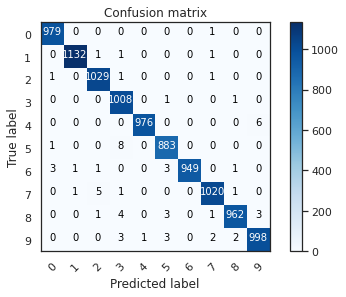

In [63]:
# Predict the values from the test dataset
y_pred = model.predict(test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert test observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [64]:
score = model.evaluate(test, y_test, verbose = 0)
print("Test Accuracy: ",score[1])

Test Accuracy:  0.9936000108718872


In [65]:
result = model.predict(test)

result = np.argmax(result, axis=1)

result = pd.Series(result, name='Label')

result.head()

0    7
1    2
2    1
3    0
4    4
Name: Label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '(Test data) Number of Digits classes predicted')

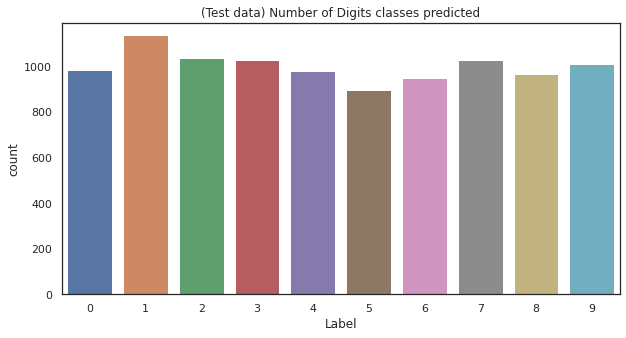

In [66]:
plt.figure(figsize=(10,5))
sns.countplot(result)
plt.title("(Test data) Number of Digits classes predicted")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '(Test data) Number of Digits classes real')

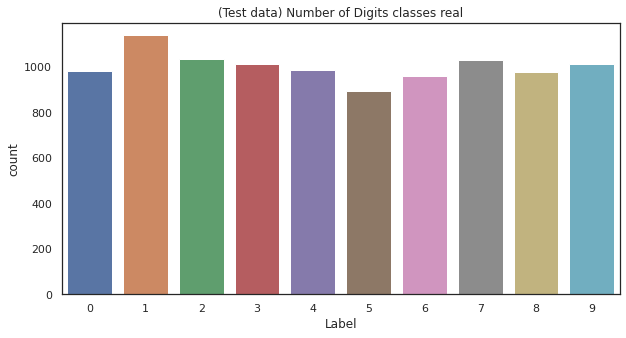

In [67]:
plt.figure(figsize=(10,5))
y_true = pd.Series(y_true, name='Label')
sns.countplot(y_true)
plt.title("(Test data) Number of Digits classes real")

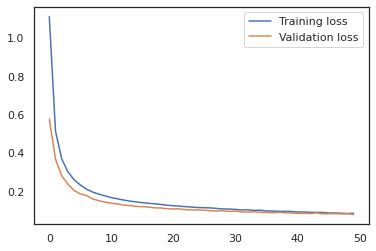

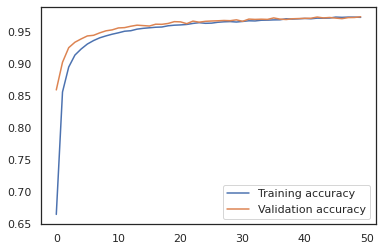

In [69]:
mostrarEvolucion(history1)

### Con data augmentation

In [70]:
model = nuevoVGG19()

#Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train)

In [71]:
model.layers[0].trainable = False

In [72]:
model.compile(optimizer = Adam(1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [73]:
epochs = 50 
batch_size = 64
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True), 
    ReduceLROnPlateau(monitor = 'val_loss', patience = 3)
]

In [74]:
# Fit the model
history1 = model.fit(datagen.flow(train,y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = (val,y_val),
                    verbose = 2, steps_per_epoch=train.shape[0] // batch_size,
                    callbacks = callbacks1)

Epoch 1/50
843/843 - 27s - loss: 1.2246 - accuracy: 0.6201 - val_loss: 0.6716 - val_accuracy: 0.8197
Epoch 2/50
843/843 - 26s - loss: 0.6400 - accuracy: 0.8117 - val_loss: 0.4762 - val_accuracy: 0.8607
Epoch 3/50
843/843 - 26s - loss: 0.4897 - accuracy: 0.8555 - val_loss: 0.3960 - val_accuracy: 0.8808
Epoch 4/50
843/843 - 26s - loss: 0.4123 - accuracy: 0.8757 - val_loss: 0.3337 - val_accuracy: 0.8968
Epoch 5/50
843/843 - 26s - loss: 0.3624 - accuracy: 0.8905 - val_loss: 0.3222 - val_accuracy: 0.8937
Epoch 6/50
843/843 - 26s - loss: 0.3323 - accuracy: 0.8995 - val_loss: 0.2994 - val_accuracy: 0.8977
Epoch 7/50
843/843 - 26s - loss: 0.3047 - accuracy: 0.9063 - val_loss: 0.2861 - val_accuracy: 0.9060
Epoch 8/50
843/843 - 26s - loss: 0.2906 - accuracy: 0.9093 - val_loss: 0.2677 - val_accuracy: 0.9118
Epoch 9/50
843/843 - 26s - loss: 0.2753 - accuracy: 0.9142 - val_loss: 0.2655 - val_accuracy: 0.9097
Epoch 10/50
843/843 - 26s - loss: 0.2633 - accuracy: 0.9187 - val_loss: 0.2543 - val_accura

#### Fine Tuning

In [75]:
model.layers[0].trainable = True

In [76]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 20,292,170
Trainable params: 20,292,170
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.compile(optimizer=Adam(1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [78]:
epochs = 20 
batch_size = 64
callbacks2 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights=True), 
    ReduceLROnPlateau(monitor = 'val_loss', patience = 3)
]

In [79]:
# Fit the model
history2 = model.fit(datagen.flow(train,y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = (val,y_val),
                    verbose = 2, steps_per_epoch=train.shape[0] // batch_size,
                    callbacks = callbacks2)

Epoch 1/20
843/843 - 40s - loss: 0.1037 - accuracy: 0.9671 - val_loss: 0.0861 - val_accuracy: 0.9700
Epoch 2/20
843/843 - 39s - loss: 0.0576 - accuracy: 0.9818 - val_loss: 0.0548 - val_accuracy: 0.9832
Epoch 3/20
843/843 - 39s - loss: 0.0407 - accuracy: 0.9875 - val_loss: 0.0381 - val_accuracy: 0.9890
Epoch 4/20
843/843 - 39s - loss: 0.0355 - accuracy: 0.9894 - val_loss: 0.0300 - val_accuracy: 0.9902
Epoch 5/20
843/843 - 39s - loss: 0.0286 - accuracy: 0.9912 - val_loss: 0.0408 - val_accuracy: 0.9878
Epoch 6/20
843/843 - 39s - loss: 0.0262 - accuracy: 0.9919 - val_loss: 0.0676 - val_accuracy: 0.9798
Epoch 7/20
843/843 - 39s - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.0325 - val_accuracy: 0.9905


#### Result

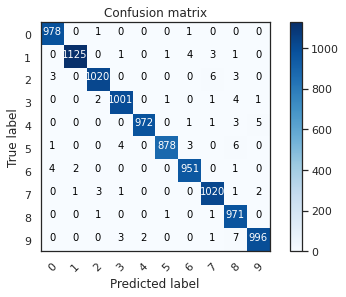

In [ ]:
# Predict the values from the test dataset
y_pred = model.predict(test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert test observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [80]:
score = model.evaluate(test, y_test, verbose = 0)
print("Test Accuracy: ",score[1])

Test Accuracy:  0.9911999702453613
